In [1]:
import numpy as np
from dotenv import load_dotenv
from sentle import sentle
import geopandas as gpd
from pathlib import Path
import os
import torch
import xarray as xr
import matplotlib.pyplot as plt
import fiona

AttributeError: module 'scipy.sparse' has no attribute 'spmatrix'

In [2]:
import numpy as np

In [7]:
env_path = Path('/net/projects/EO4BK/WP1/P1-EO4BK/scripts/EO4BK-WP1-P1/.env')
load_dotenv(dotenv_path=env_path)
# Set resolution of the grid that  i want to load
res = 10
nuts3 = 'DE12C'
# Path to LUCAS Copernicus file
lcs_poly_path = f"{os.getenv('LUCS_CPN_POLY_DE12C')}/LUCAS_CPNS_{nuts3}_sample.gpkg"
lcs_cpns_poly_data = gpd.read_file(lcs_poly_path)
output_zarr_path = f"{os.getenv('MINICUBES_PATH')}/0_{res}_{nuts3}.zarr"
#polygon = lcs_cpns_poly_data[0:1] # for selecting a single polygon 
# polygon

In [4]:
import numpy as np


In [8]:
# Set CUDA environment
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
print(f"> Available CUDA devices: {torch.cuda.device_count()}")

> Available CUDA devices: 1


In [12]:
subset = lcs_cpns_poly_data[:3]
subset.crs

<Projected CRS: EPSG:3035>
Name: ETRS89-extended / LAEA Europe
Axis Info [cartesian]:
- Y[north]: Northing (metre)
- X[east]: Easting (metre)
Area of Use:
- name: Europe - European Union (EU) countries and candidates. Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Iceland; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal including Madeira and Azores; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain including Canary Islands; Sweden; Switzerland; Türkiye (Turkey); United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-35.58, 24.6, 44.83, 84.73)
Coordinate Operation:
- name: Europe Equal Area 2001
- method: Lambert Azimuthal Equal Area
Datum: Eur

In [15]:
# lcs_cpns_poly_data = subset
bounds = []
for i in range(1,len(subset.index)+1):
    j = i - 1 
    geometries = subset[j:i].geometry.iloc[0].bounds    
    bounds.append(geometries)


bounds = np.array(bounds) # convert bounds from nested list into array, because bounds is a nested list, and multidimensional slicing is not possible
bounds_left = np.array(bounds[:,0], dtype=np.int32)  # int() expect one variable and not a list, bounds[:,0] is the first column of the ndarray
bounds_bottom = np.array(bounds[:,1], dtype=np.int32) # bounds[:,1] is the second column of the ndarray
bounds_right = np.array(bounds[:,2], dtype=np.int32) # bounds[:,2] is the third column of the ndarray
bounds_top = np.array(bounds[:,3], dtype=np.int32) # bounds[:,3] is the fourth column of the ndarray 
lcs_crs = subset.crs   # to get the coordinate system information 


da = sentle.process(
    target_crs=lcs_crs,
    bound_left=bounds_left,
    bound_bottom=bounds_bottom,
    bound_right=bounds_right,
    bound_top=bounds_top,
    datetime="2024-07-01/2024-07-31",
    target_resolution=10,
    S2_mask_snow=True,
    S2_cloud_classification=True,
    S2_cloud_classification_device="cuda",
    S1_assets=["vv", "vh"],
    S2_apply_snow_mask=True,
    S2_apply_cloud_mask=True,
    time_composite_freq="7d",
    # NOTE clemens: this can be set to 40
    num_workers=7,
)


2024-09-16 16:15:04,976 - distributed.protocol.core - INFO - Failed to serialize (can not serialize 'GeoDataFrame' object); falling back to pickle. Be aware that this may degrade performance.
ERROR 1: PROJ: internal_proj_create_from_database: /net/home/dschierbaum/.conda/envs/wp1/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 3 is expected. It comes from another PROJ installation.


CRSError: The WKT could not be parsed. OGR Error code 6

In [134]:

bounds = lcs_cpns_poly_data[0:1].geometry.iloc[0].bounds
bound_left = int(bounds[0])
bound_bottom = int(bounds[1])
bound_right = int(bounds[2])
bound_top = int(bounds[3])
equi7_crs = lcs_cpns_poly_data.crs
print(f"Resolution: {res}")

da = sentle.process(
    target_crs=equi7_crs,
    bound_left=bound_left,
    bound_bottom=bound_bottom,
    bound_right=bound_right,
    bound_top=bound_top,
    datetime="2024-05-01/2024-07-31",
    target_resolution=20,
    S2_mask_snow=True,
    S2_cloud_classification=True,
    S2_cloud_classification_device="cuda",
    S1_assets=["vv", "vh"],
    S2_apply_snow_mask=True,
    S2_apply_cloud_mask=True,
    time_composite_freq="7d",
    # NOTE clemens: this can be set to 40
    num_workers=7,
)

sentle.save_as_zarr(da, path=output_zarr_path)

Resolution: 10


/net/home/dschierbaum/.conda/envs/wp1/lib/python3.11/site-packages/sentle/sentle.py:881: UserWarning: Specified top/bottom bounds are not perfectly divisable by specified target_resolution. The resulting coverage will be rounded up to the next pixel value.
  warnings.warn(
/net/home/dschierbaum/.conda/envs/wp1/lib/python3.11/site-packages/sentle/sentle.py:888: UserWarning: Specified left/right bounds are not perfectly divisable by specified target_resolution. The resulting coverage will be rounded up to the next pixel value.
  warnings.warn(


In [233]:
intersected_gdf_equi7.point_id[3]

42122814

In [230]:
import geopandas as gpd
from sentle import sentle
import os
from dotenv import load_dotenv
from pathlib import Path
import torch
import concurrent.futures
import logging
import time

intersected_gdf_equi7 = gpd.read_file(grid_path)

# Configure logging
logging.basicConfig(
    level=logging.INFO,  # Set the desired logging level
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),  # Logs to the console
        logging.FileHandler('sentinel_processing_3.log')  # Logs to a file
    ]
)
logger = logging.getLogger()

def load_sentle(grid_path, idx, res):
    """
    Load Sentinel data using the Sentle library for a given grid.
    """
    try:
        intersected_gdf_equi7 = gpd.read_file(grid_path)
        bounds = idx + 1
        bounds = intersected_gdf_equi7[idx:bounds].geometry.iloc[0].bounds
        bound_left = int(bounds[0])
        bound_bottom = int(bounds[1])
        bound_right = int(bounds[2])
        bound_top = int(bounds[3])
        equi7_crs = intersected_gdf_equi7.crs
        logger.info(f"Resolution: {res}")

        da = sentle.process(
            target_crs=equi7_crs,
            bound_left=bound_left,
            bound_bottom=bound_bottom,
            bound_right=bound_right,
            bound_top=bound_top,
            datetime="2022-06-01/2022-07-31",
            target_resolution=res,
            S2_mask_snow=True,
            S2_cloud_classification=True,
            S2_cloud_classification_device="cpu",
            S1_assets=["vv", "vh"],
            S2_apply_snow_mask=True,
            S2_apply_cloud_mask=True,
            time_composite_freq="7d",
            # NOTE clemens: this can be set to 40
            num_workers=7,
        )
        return da
    except Exception as e:
        logger.error(f"Error in load_sentle function for index {idx}: {e}")
        raise

def process_and_save(grid_path, idx, point_id, res):
    """
    Process and save Sentinel data for a given index.
    """
    try:
        logger.info(f"> Load the Minicube {idx} ...")
        da = load_sentle(grid_path=grid_path, idx=idx, res=res)
        logger.info(f"> Save the Minicube {idx} ...")
        output_zarr_path = f"{os.getenv('MINICUBES_PATH')}/LUCAS_CPNS_{point_id}_{res}.zarr"
        sentle.save_as_zarr(da, path=output_zarr_path)
        logger.info(f"> Successfully saved the Minicube {idx} at {output_zarr_path} ...")
    except Exception as e:
        logger.error(f"An error occurred for index {idx}: {e}")

def main():
    start_time = time.time()  # Capture the start time

    try:
        # Load the Environment variables
        env_path = Path('/net/projects/EO4BK/WP1/P1-EO4BK/scripts/EO4BK-WP1-P1/.env')
        load_dotenv(dotenv_path=env_path)

        # NOTE clemens
        # if below does not work, try to set the CUDA_VISIBLE_DEVICES through the terminal before running the script
        # with `export CUDA_VISIBLE_DEVICES=2`

        # Set CUDA environment
        os.environ["CUDA_VISIBLE_DEVICES"] = "2"
        logger.info(f"> Available CUDA devices: {torch.cuda.device_count()}")

        # Set resolution of the grid that  i want to load
        res = 10
        nuts3 = 'DE12C'
        # Path to grid_file
        grid_path = f"{os.getenv('LUCS_CPN_POLY_DE12C')}/LUCAS_CPNS_{nuts3}_sample.gpkg"
        
        #intersected_gdf_equi7 = gpd.read_file(grid_path)
        start_idx = 0
        end_idx = 4 #len(intersected_gdf_equi7) - 1  # This is up to 3997  so i just tried with a shorter range for testing


        # NOTE clemens
        # do a simple for-loop here, the sentle process function is already parallelized
        for idx in range(start_idx, end_idx + 1):
            process_and_save(grid_path, idx, intersected_gdf_equi7.point_id[idx], res)

        # # Use ThreadPoolExecutor with a limit of 5 concurrent workers
        # with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        #     futures = [executor.submit(process_and_save, grid_path, idx, res) for idx in range(start_idx, end_idx + 1)]
        #     # Wait for all futures to complete
        #     for future in concurrent.futures.as_completed(futures):
        #         pass  # You can handle results if needed


    except Exception as e:
        logger.error(f"An error occurred in the main execution: {e}")

    end_time = time.time()  # Capture the end time
    elapsed_time = end_time - start_time
    logger.info(f"Total execution time: {elapsed_time:.2f} seconds")

if __name__ == "__main__":
    main()


/net/home/dschierbaum/.conda/envs/wp1/lib/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2024-09-11 14:18:32,819 - INFO - > Available CUDA devices: 1
2024-09-11 14:18:32,820 - INFO - > Load the Minicube 1 ...
2024-09-11 14:18:32,854 - INFO - Resolution: 10
/net/home/dschierbaum/.conda/envs/wp1/lib/python3.11/site-packages/sentle/sentle.py:881: UserWarning: Specified top/bottom bounds are not perfectly divisable by specified target_resolution. The resulting coverage will be rounded up to the next pixel value.
  warnings.warn(
/net/home/dschierbaum/.conda/envs/wp1/lib/python3.11/site-packages/sentle/sentle.py:888: UserWarning: Specified left/right bounds are not perfectly divisable by specified target_resolution. The resulting coverage will be rounded up to the next pixel value.
  warnings.warn(
2024-09-11 14:18:34,763 - INFO - > Save the Minicube 1 ...
2024-09-11 14:19:15,101 - INFO - > Successfully saved 

In [8]:
intersected_gdf_equi7 = lcs_cpns_poly_data

In [5]:
intersected_gdf_equi7.point_id[1:5]

NameError: name 'intersected_gdf_equi7' is not defined

In [314]:
intersected_gdf_equi7.point_id[4]

42302820

In [447]:
test_minicube = xr.open_zarr(f"{os.getenv('MINICUBES_PATH')}/LUCAS_CPNS_{intersected_gdf_equi7.point_id[2]}_10.zarr")
test_minicube.sentle

<xarray.DataArray 'sentle' (time: 9, band: 14, y: 4, x: 5)> Size: 10kB
dask.array<open_dataset-sentle, shape=(9, 14, 4, 5), dtype=float32, chunksize=(1, 12, 4, 5), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) <U3 168B 'B01' 'B02' 'B03' 'B04' ... 'B11' 'B12' 'vv' 'vh'
  * time     (time) datetime64[ns] 72B 2022-07-28 2022-07-21 ... 2022-06-02
  * x        (x) float32 20B 4.224e+06 4.224e+06 4.224e+06 4.224e+06 4.224e+06
  * y        (y) float32 16B 2.82e+06 2.82e+06 2.82e+06 2.82e+06

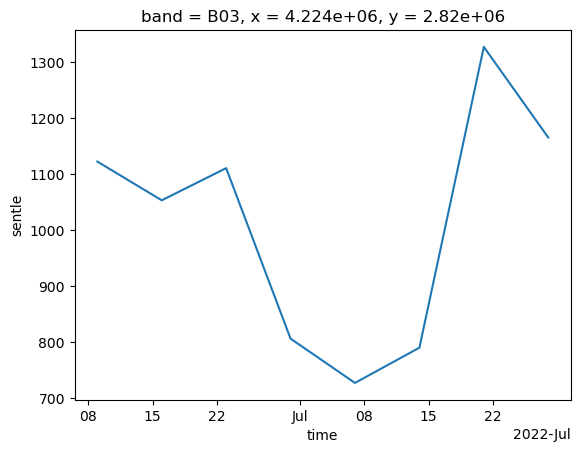

In [448]:
# Plot Time-Series

ds_band = test_minicube.sel(band = ['B03','B04','B05'])
singleband = ds_band.sel(band = 'B03')
pixel_timeseries = singleband.isel(x = 1, y = 1)
pixel_timeseries.sentle.plot()

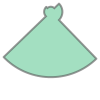

In [446]:
# Plot Map 
# Extract the time series for the specified pixel and band


# spatial = ds_band.isel(time=5)
# spatial.sentle.sel(band =['B04']).plot(ax  = ax)
lcs_cpns_poly_data[lcs_cpns_poly_data['point_id'] == 42242820].geometry.iloc[0]  # point id is a int32, so index is not in ''



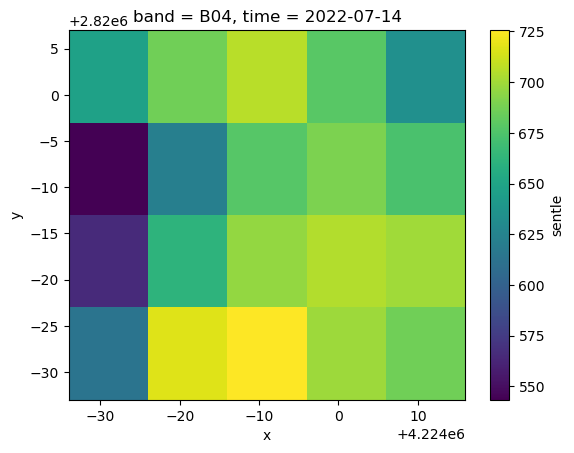

In [449]:
spatial = ds_band.isel(time=2)
spatial.sentle.sel(band =['B04']).plot()

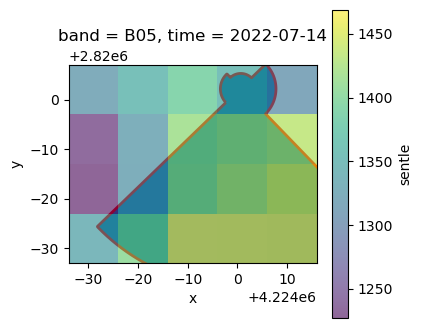

In [450]:
fig, ax = plt.subplots(figsize = (4,4))

lcs_cpns_poly_data[lcs_cpns_poly_data['point_id'] == 42242820].plot(ax = ax, edgecolor = 'red', linewidth = 2)
spatial.sentle.sel(band =['B05']).plot(ax = ax, cmap = 'viridis', alpha = 0.6)


In [14]:
import shapely

In [364]:
test_array_42302820 = xr.open_zarr(f"{os.getenv('MINICUBES_PATH')}/LUCAS_CPNS_{intersected_gdf_equi7.point_id[1]}_10.zarr")
test_array_42302820

<xarray.Dataset> Size: 18kB
Dimensions:  (band: 14, time: 9, y: 5, x: 7)
Coordinates:
  * band     (band) <U3 168B 'B01' 'B02' 'B03' 'B04' ... 'B11' 'B12' 'vv' 'vh'
  * time     (time) datetime64[ns] 72B 2022-07-28 2022-07-21 ... 2022-06-02
  * x        (x) float32 28B 4.208e+06 4.208e+06 ... 4.208e+06 4.208e+06
  * y        (y) float32 20B 2.818e+06 2.818e+06 2.818e+06 2.818e+06 2.818e+06
Data variables:
    sentle   (time, band, y, x) float32 18kB dask.array<chunksize=(1, 12, 5, 7), meta=np.ndarray>

In [440]:
# subset array
test_array_42302820 = xr.open_zarr(f"{os.getenv('MINICUBES_PATH')}/LUCAS_CPNS_{intersected_gdf_equi7.point_id[2]}_10.zarr")
test_array_42302820 = test_array_42302820.sentle.sel(time = '2022-07-28', band = 'B02')

# subset the gkpg with the same id as the array 
poly_42302820 = intersected_gdf_equi7[intersected_gdf_equi7['point_id'] == 42242820]




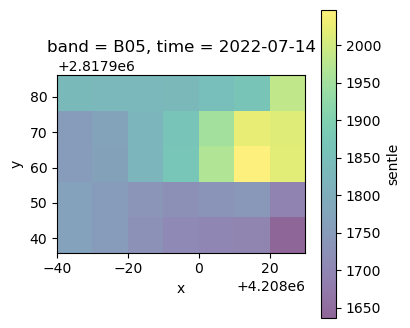

In [444]:
fig, ax = plt.subplots(figsize = (4,4))

lcs_cpns_poly_data[lcs_cpns_poly_data['point_id'] == 42242820].plot(ax = ax, edgecolor = 'red', linewidth = 2)
spatial.sentle.sel(band =['B05']).plot(ax = ax, cmap = 'viridis', alpha = 0.6)


In [17]:
import shapely

In [451]:
# subset array
test_array_42302820 = xr.open_zarr(f"{os.getenv('MINICUBES_PATH')}/LUCAS_CPNS_{intersected_gdf_equi7.point_id[2]}_10.zarr")
test_array_42302820 = test_array_42302820.sentle.sel(time = '2022-07-28', band = 'B02')

# subset the gkpg with the same id as the array 
poly_42302820 = intersected_gdf_equi7[intersected_gdf_equi7['point_id'] == 42242820]

test the git so i write some stuff

In [19]:
import rioxarray
from shapely.geometry import mapping 

In [452]:
test_array_42302820.rio.set_spatial_dims(x_dim = "x", y_dim = "y")
test_array_42302820.rio.write_crs(poly_42302820.crs, inplace = True)
clipped = test_array_42302820.rio.clip(poly_42302820.geometry.apply(mapping), poly_42302820.crs, drop = False)
clipped

<xarray.DataArray 'sentle' (y: 4, x: 5)> Size: 80B
dask.array<where, shape=(4, 5), dtype=float32, chunksize=(4, 5), chunktype=numpy.ndarray>
Coordinates:
    band         <U3 12B 'B02'
    time         datetime64[ns] 8B 2022-07-28
  * x            (x) float32 20B 4.224e+06 4.224e+06 ... 4.224e+06 4.224e+06
  * y            (y) float32 16B 2.82e+06 2.82e+06 2.82e+06 2.82e+06
    spatial_ref  int64 8B 0

In [ ]:
from geocube.api.core import make_geocube
out_grid = make_geocube(poly_42302820, like = test_array_42302820)


In [ ]:
import rioxarray
from shapely.geometry import mapping

raster_42062802 = raster_42062802.rio.write_crs(poly_42062802.crs)

# 4. Clip the xarray dataset using the geopandas GeoDataFrame
# Convert the geodataframe geometry to a GeoJSON-like dict format
clipped_ds = raster_42062802.rio.clip(poly_42062802.geometry.apply(mapping), poly_42062802.crs)

### Try to find the inner circle of the polygon, to ensure that just pixel from one land cover class are sampled

https://github.com/OpenStitching/lir # did not work for now

In [126]:
test = poly_42302820

<Axes: title={'center': 'band = B05, time = 2022-07-14'}, xlabel='x', ylabel='y'>

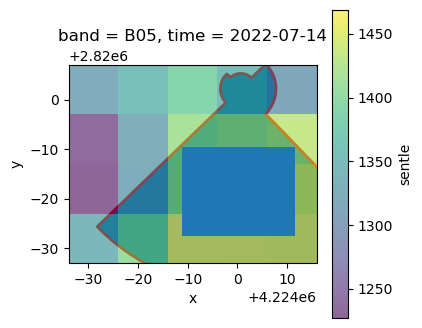

In [458]:
fig, ax = plt.subplots(figsize = (4,4))


lcs_cpns_poly_data[lcs_cpns_poly_data['point_id'] == 42242820].plot(ax = ax, edgecolor = 'red', linewidth = 2)
spatial.sentle.sel(band =['B05']).plot(ax = ax, cmap = 'viridis', alpha = 0.6)
test.plot(ax = ax)

In [133]:
square_gdf = gpd.GeoSeries(largest_square)

NameError: name 'largest_square' is not defined

In [413]:
max_square = poly_42302820.envelope.geometry  # create the maximum square, that is outsite the polygon
# max_x = max_square.bounds.maxx   # get the x max point
# min_x = max_square.bounds.minx   # get the x min point
# max_y = max_square.bounds.maxy   # get the y max point
# min_y = max_square.bounds.miny   # get the y min point

# find out the width and height of the maximum square 

# max_width = max_x - min_x
# max_height = max_y - min_y

# max_area = max_width * max_height   # calculate the area of the maximum square outside the polygon
 
# max_area <= poly_42302820.area      # the square must be smaller than the area of the polygon to fit insite
#Alternative, check if the polygon fully contains the max_square 
poly_42302820.contains(max_square)

# max_width_ = max_width - 1
# max_height_ = max_height - 1

# max_area_ = max_height_ * max_width_

#poly_42302820.contains(max_square)

max_square_smaller = affinity.scale(max_square.geometry.iloc[0], xfact=-0.2, yfact=-0.2) # https://shapely.readthedocs.io/en/stable/manual.html#shapely.affinity.scale
poly_42302820.contains(max_square_smaller)
gdf_max_square_smaller = gpd.GeoDataFrame(index=[0], crs = poly_42302820.crs, geometry=[max_square_smaller])

poly_42302820.contains(max_square_smaller)

1    True
dtype: bool

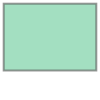

In [414]:
max_square.geometry.iloc[0]

In [270]:
poly_42302820.contains(max_square_smaller)

4    True
dtype: bool

In [259]:
poly_42302820.contains(max_square)

4    False
dtype: bool

<Axes: >

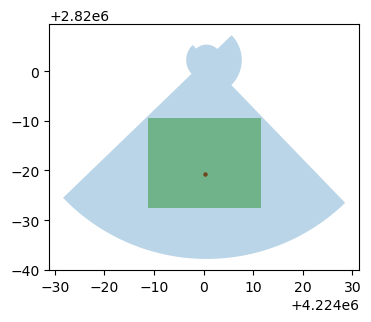

In [506]:
fig, ax = plt.subplots(figsize = (4,4))
poly_42302820.centroid.geometry.plot(ax = ax, color = 'red', markersize = 5)
poly_42302820.plot(ax = ax, alpha = 0.3)
test.plot(ax=ax, alpha = 0.4, color = 'green')



In [472]:
poly_42302820.contains(poly_42302820.envelope).any() == True

False

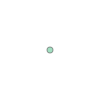

In [479]:
poly_42302820.centroid.geometry.iloc[0]

In [504]:
# Fast but not necessarely the best, because the initial square determines the output

def largest_square_in_multipolygon(multipolygon):
    '''
    multipolygon = geopandas.geodataframe.GeoDataFrame
    '''

    # construct the initial square

    int_square = multipolygon.envelope

    # Check if initial polygon fits inside multipolygon, hint: it won't
    if multipolygon.contains(int_square).any() == True:
        # but if it would fit then return the initial square 
        return int_square
    else:
        # if it does not fit:
        xfact_ = 1.0  # set initial scaling factor 
        yfact_ = 1.0  # set initial scaling factor 
        for _ in range(100):  # _ as a place holder for nothing, maximum iteration is 100
            # https://shapely.readthedocs.io/en/stable/manual.html#shapely.affinity.scale
            scaled_square = affinity.scale(int_square.geometry.iloc[0], xfact= xfact_, yfact = yfact_, origin=(multipolygon.centroid.geometry.iloc[0]))
            # check if the scaled version is smaller than the multipolygon
            if multipolygon.contains(scaled_square).all() == True:
                # shapely must be transformed into GeoDataFrame 
                scaled_square_gdf = gpd.GeoDataFrame(index=[0], crs = multipolygon.crs, geometry=[scaled_square])
                # return the GeoDataFrame of the scaled shapely square
                return scaled_square_gdf
            # the factor by which the initial scaling is reduced 
            else:
                xfact_ -=0.01
                yfact_ -=0.01
            # when no square is found and the scaling factors are still bigger than zero
            # the loop is terminated, and nothing is returned
                if xfact_ <= 0 or yfact_ <= 0:
                    print('Scaling factor is now 0')
                    break
        return None


In [505]:
test = largest_square_in_multipolygon(poly_42302820)

<Axes: >

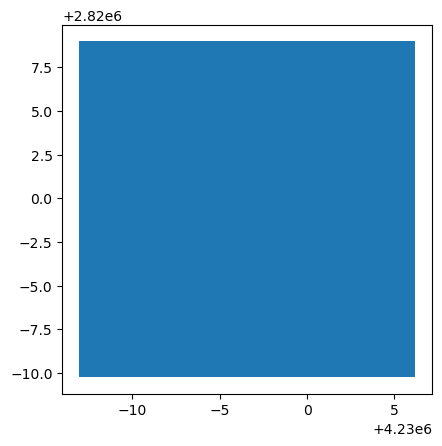

In [213]:
gdf_ = gpd.GeoDataFrame(index=[0], crs = poly_42302820.crs, geometry=[max_square_smaller])


In [209]:
max_square_smaller.exterior.coords[:]

[(4230006.202919533, 2820008.9889108236),
 (4229986.949749542, 2820008.9889108236),
 (4229986.949749542, 2819989.750321919),
 (4230006.202919533, 2819989.750321919),
 (4230006.202919533, 2820008.9889108236)]

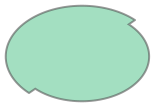

In [196]:
triangle = Polygon([(1, 1), (2, 3), (3, 1)])
triangle_a = affinity.scale(poly_42302820.geometry.iloc[0], xfact=1.5, yfact=-1)
#triangle_b = affinity.scale(triangle, xfact=2, origin=(1,1))
#triangle_a
triangle_a

In [172]:
from shapely import affinity
scaled_polygon = affinity.scale(poly_42302820.geometry, xfact=1.2, yfact=1.2)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [135]:
get_maximal_rectangle(poly_42302820)

TypeError: unsupported operand type(s) for -: 'str' and 'str'